In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csiro-biomass/sample_submission.csv
/kaggle/input/csiro-biomass/train.csv
/kaggle/input/csiro-biomass/test.csv
/kaggle/input/csiro-biomass/test/ID1001187975.jpg
/kaggle/input/csiro-biomass/train/ID2099464826.jpg
/kaggle/input/csiro-biomass/train/ID2037861084.jpg
/kaggle/input/csiro-biomass/train/ID1211362607.jpg
/kaggle/input/csiro-biomass/train/ID1853508321.jpg
/kaggle/input/csiro-biomass/train/ID193102215.jpg
/kaggle/input/csiro-biomass/train/ID698608346.jpg
/kaggle/input/csiro-biomass/train/ID1859251563.jpg
/kaggle/input/csiro-biomass/train/ID1880764911.jpg
/kaggle/input/csiro-biomass/train/ID853954911.jpg
/kaggle/input/csiro-biomass/train/ID1403107574.jpg
/kaggle/input/csiro-biomass/train/ID1781353117.jpg
/kaggle/input/csiro-biomass/train/ID384648061.jpg
/kaggle/input/csiro-biomass/train/ID1563418511.jpg
/kaggle/input/csiro-biomass/train/ID2125100696.jpg
/kaggle/input/csiro-biomass/train/ID482555369.jpg
/kaggle/input/csiro-biomass/train/ID638711343.jpg
/kaggle/input/c

In [44]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import joblib
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import timm
from torchvision import transforms

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print("="*70)

Using device: cpu


Imports all libraries needed.

Checks for GPU availability for faster training.

In [45]:
# ===== CELL 2: Load and Prepare Data =====
print("\n📊 LOADING DATA...")
DATA_DIR = "/kaggle/input/csiro-biomass"

train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")


📊 LOADING DATA...
Train samples: 1785
Test samples: 5


Loads train/test CSVs.

sample_submission.csv shows required submission format.

In [46]:
# ===== CELL 3: Encode Metadata =====
print("\n🔧 ENCODING METADATA...")
le_state = LabelEncoder()
le_species = LabelEncoder()

# Train metadata
train_df["State_enc"] = le_state.fit_transform(train_df["State"])
train_df["Species_enc"] = le_species.fit_transform(train_df["Species"])
train_df["Sampling_DOY"] = pd.to_datetime(train_df["Sampling_Date"]).dt.dayofyear

# Test metadata with defaults
test_df["State_enc"] = 0
test_df["Species_enc"] = 0
test_df["Sampling_DOY"] = 180

# Fill missing metadata in test
for col in ["Pre_GSHH_NDVI", "Height_Ave_cm"]:
    test_df[col] = train_df[col].mean()

META_COLS = ["Pre_GSHH_NDVI", "Height_Ave_cm", "State_enc", "Species_enc", "Sampling_DOY"]
TARGETS = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]



🔧 ENCODING METADATA...


In [47]:
# ===== CELL 4: Convert to Image-Level Data =====
print("\n🔄 CONVERTING TO IMAGE-LEVEL FORMAT...")

# Pivot so each image has all 5 targets
train_wide = train_df.pivot_table(
    index=["image_path"],
    columns="target_name",
    values="target"
).reset_index()

train_wide = train_wide.merge(
    train_df.drop_duplicates("image_path")[["image_path"] + META_COLS],
    on="image_path",
    how="left"
)

# Clean data
for col in META_COLS:
    train_wide[col] = pd.to_numeric(train_wide[col], errors='coerce')
    train_wide[col] = train_wide[col].fillna(train_wide[col].mean())

for col in TARGETS:
    train_wide[col] = pd.to_numeric(train_wide[col], errors='coerce')
    train_wide[col] = train_wide[col].fillna(0)

print(f"Unique images: {len(train_wide)}")


🔄 CONVERTING TO IMAGE-LEVEL FORMAT...
Unique images: 357


In [48]:
# ===== CELL 5: Train/Validation Split =====
print("\n✂️ SPLITTING DATA...")

gkf = GroupKFold(n_splits=5)
groups = train_wide["image_path"]
train_idx, val_idx = next(gkf.split(train_wide, groups=groups))

train_data = train_wide.iloc[train_idx].copy()
val_data = train_wide.iloc[val_idx].copy()

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")


✂️ SPLITTING DATA...
Train samples: 285
Validation samples: 72


In [49]:
# ===== CELL 6: Feature Extraction Function for ML Models =====
print("\n🎨 SETTING UP FEATURE EXTRACTION...")

def extract_image_features(image_path, img_dir):
    """Extract hand-crafted features from image for Random Forest and SVR"""
    try:
        img_full_path = os.path.join(img_dir, image_path.split("/")[-1])
        img = cv2.imread(img_full_path)
        if img is None:
            return [0] * 13  # Return zeros if image can't be loaded
        
        img = cv2.resize(img, (224, 224))
        features = []
        
        # Color statistics (mean, std for R,G,B)
        for channel in range(3):
            features.append(float(img[:, :, channel].mean()))
            features.append(float(img[:, :, channel].std()))
        
        # Texture features using gradients
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        features.append(float(np.abs(grad_x).mean()))
        features.append(float(np.abs(grad_y).mean()))
        
        # HSV color space statistics
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        features.append(float(hsv[:, :, 0].mean()))  # Hue
        features.append(float(hsv[:, :, 1].mean()))  # Saturation
        features.append(float(hsv[:, :, 2].mean()))  # Value
        
        # Green channel dominance (vegetation indicator)
        features.append(float((img[:, :, 1] > img[:, :, 0]).sum()))
        features.append(float((img[:, :, 1] > img[:, :, 2]).sum()))
        
        return features
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return [0] * 13


🎨 SETTING UP FEATURE EXTRACTION...


In [50]:
# ===== CELL 7: Dataset Class for Neural Network =====
class BiomassDataset(Dataset):
    def __init__(self, df, img_dir, transform, train=True):
        self.df = df.reset_index(drop=True).copy()
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_path"].split("/")[-1])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        meta_values = row[META_COLS].values.astype(np.float32)
        meta = torch.tensor(meta_values, dtype=torch.float32)

        if self.train:
            target_values = row[TARGETS].values.astype(np.float32)
            target = torch.tensor(target_values, dtype=torch.float32)
            return image, meta, target

        return image, meta, row["image_path"]

Returns image + metadata + 5-target vector for training.

For test, returns image + metadata + image_path for submission.

In [51]:
# ===== CELL 8: Image Transformations =====
IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

GroupKFold ensures no image leakage.

Maintains validation accuracy close to true generalization.

In [52]:
# ===== CELL 9: Create DataLoaders for Neural Network =====
train_ds = BiomassDataset(train_data, f"{DATA_DIR}/train", train_tfms, train=True)
val_ds = BiomassDataset(val_data, f"{DATA_DIR}/train", test_tfms, train=True)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

In [53]:

print("\n" + "="*70)
print("🧠 ALGORITHM 1: NEURAL NETWORK (Deep Learning)")
print("="*70)

class NeuralNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Image feature extractor
        self.backbone = timm.create_model("efficientnet_b0", pretrained=False, num_classes=0)
        
        # Metadata processor
        self.meta_net = nn.Sequential(
            nn.Linear(len(META_COLS), 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Fusion head
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 5)
        )

    def forward(self, img, meta):
        img_feat = self.backbone(img)
        meta_feat = self.meta_net(meta)
        x = torch.cat([img_feat, meta_feat], dim=1)
        return self.head(x)


nn_model = NeuralNetModel().to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in nn_model.parameters()):,}")

# Loss function and optimizer
WEIGHTS = torch.tensor([1, 1, 1, 2, 5], device=DEVICE, dtype=torch.float32)

def weighted_mse(pred, target):
    return ((pred - target)**2 * WEIGHTS).mean()

optimizer = torch.optim.AdamW(nn_model.parameters(), lr=3e-4, weight_decay=1e-4)

# Train Neural Network
EPOCHS = 10
print(f"\n🏋️ Training Neural Network for {EPOCHS} epochs...")

best_nn_loss = float('inf')

for epoch in range(EPOCHS):
    # Training
    nn_model.train()
    train_loss = 0
    
    for img, meta, target in train_loader:
        img = img.to(DEVICE).float()
        meta = meta.to(DEVICE).float()
        target = target.to(DEVICE).float()
        
        optimizer.zero_grad()
        preds = nn_model(img, meta)
        loss = weighted_mse(preds, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(nn_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation
    nn_model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for img, meta, target in val_loader:
            img = img.to(DEVICE).float()
            meta = meta.to(DEVICE).float()
            target = target.to(DEVICE).float()
            
            preds = nn_model(img, meta)
            loss = weighted_mse(preds, target)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_nn_loss:
        best_nn_loss = avg_val_loss
        torch.save(nn_model.state_dict(), 'neural_network_model.pth')

# Load best model and evaluate
nn_model.load_state_dict(torch.load('neural_network_model.pth'))
nn_model.eval()

nn_preds = []
nn_targets = []

with torch.no_grad():
    for img, meta, target in val_loader:
        img, meta = img.to(DEVICE), meta.to(DEVICE)
        preds = nn_model(img, meta)
        nn_preds.append(preds.cpu().numpy())
        nn_targets.append(target.cpu().numpy())

nn_preds = np.vstack(nn_preds)
nn_targets = np.vstack(nn_targets)

print("\n📊 Neural Network Validation Results:")
print(f"{'Target':<15} {'R²':<10} {'MAE (g)':<10} {'RMSE (g)':<10}")
print("-" * 50)

nn_r2_scores = []
for i, target_name in enumerate(TARGETS):
    r2 = r2_score(nn_targets[:, i], nn_preds[:, i])
    mae = mean_absolute_error(nn_targets[:, i], nn_preds[:, i])
    rmse = np.sqrt(mean_squared_error(nn_targets[:, i], nn_preds[:, i]))
    nn_r2_scores.append(r2)
    print(f"{target_name:<15} {r2:<10.3f} {mae:<10.2f} {rmse:<10.2f}")

overall_r2_nn = r2_score(nn_targets.flatten(), nn_preds.flatten())
overall_mae_nn = mean_absolute_error(nn_targets.flatten(), nn_preds.flatten())
print("-" * 50)
print(f"{'OVERALL':<15} {overall_r2_nn:<10.3f} {overall_mae_nn:<10.2f}")


🧠 ALGORITHM 1: NEURAL NETWORK (Deep Learning)
Model parameters: 4,370,305

🏋️ Training Neural Network for 10 epochs...
Epoch 1/10 - Train Loss: 2669.3951 | Val Loss: 1991.2535
Epoch 2/10 - Train Loss: 1468.0543 | Val Loss: 1555.8510
Epoch 3/10 - Train Loss: 1021.3182 | Val Loss: 1045.0150
Epoch 4/10 - Train Loss: 856.7251 | Val Loss: 884.0528
Epoch 5/10 - Train Loss: 633.8907 | Val Loss: 681.4799
Epoch 6/10 - Train Loss: 598.5645 | Val Loss: 524.6211
Epoch 7/10 - Train Loss: 540.9941 | Val Loss: 731.4366
Epoch 8/10 - Train Loss: 505.4914 | Val Loss: 568.1787
Epoch 9/10 - Train Loss: 411.4390 | Val Loss: 523.8145
Epoch 10/10 - Train Loss: 374.8804 | Val Loss: 478.9384

📊 Neural Network Validation Results:
Target          R²         MAE (g)    RMSE (g)  
--------------------------------------------------
Dry_Green_g     0.635      12.08      17.34     
Dry_Dead_g      0.112      9.63       12.75     
Dry_Clover_g    0.040      7.83       11.71     
GDM_g           0.592      11.81      

In [54]:
# ============================================================================
# ALGORITHM 2: RANDOM FOREST (Ensemble Method)
# ============================================================================

print("\n" + "="*70)
print("🌲 ALGORITHM 2: RANDOM FOREST (Ensemble Method)")
print("="*70)

# Extract features for train and validation
print("Extracting image features for training set...")
train_img_features = []
for i, img_path in enumerate(train_data["image_path"]):
    if i % 50 == 0:
        print(f"  Progress: {i}/{len(train_data)}", end='\r')
    features = extract_image_features(img_path, f"{DATA_DIR}/train")
    train_img_features.append(features)
print(f"  Completed: {len(train_data)}/{len(train_data)}")

print("Extracting image features for validation set...")
val_img_features = []
for i, img_path in enumerate(val_data["image_path"]):
    if i % 20 == 0:
        print(f"  Progress: {i}/{len(val_data)}", end='\r')
    features = extract_image_features(img_path, f"{DATA_DIR}/train")
    val_img_features.append(features)
print(f"  Completed: {len(val_data)}/{len(val_data)}")

# Combine image features with metadata
X_train_rf = np.hstack([
    np.array(train_img_features),
    train_data[META_COLS].values
])

X_val_rf = np.hstack([
    np.array(val_img_features),
    val_data[META_COLS].values
])

y_train_rf = train_data[TARGETS].values
y_val_rf = val_data[TARGETS].values

# Scale features
scaler_rf = StandardScaler()
X_train_rf = scaler_rf.fit_transform(X_train_rf)
X_val_rf = scaler_rf.transform(X_val_rf)

print(f"\nFeature shape: {X_train_rf.shape}")

# Train Random Forest
print("\n🏋️ Training Random Forest...")
rf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
)

rf_model.fit(X_train_rf, y_train_rf)
rf_preds = rf_model.predict(X_val_rf)

print("\n📊 Random Forest Validation Results:")
print(f"{'Target':<15} {'R²':<10} {'MAE (g)':<10} {'RMSE (g)':<10}")
print("-" * 50)

rf_r2_scores = []
for i, target_name in enumerate(TARGETS):
    r2 = r2_score(y_val_rf[:, i], rf_preds[:, i])
    mae = mean_absolute_error(y_val_rf[:, i], rf_preds[:, i])
    rmse = np.sqrt(mean_squared_error(y_val_rf[:, i], rf_preds[:, i]))
    rf_r2_scores.append(r2)
    print(f"{target_name:<15} {r2:<10.3f} {mae:<10.2f} {rmse:<10.2f}")

overall_r2_rf = r2_score(y_val_rf.flatten(), rf_preds.flatten())
overall_mae_rf = mean_absolute_error(y_val_rf.flatten(), rf_preds.flatten())
print("-" * 50)
print(f"{'OVERALL':<15} {overall_r2_rf:<10.3f} {overall_mae_rf:<10.2f}")

# Save Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(scaler_rf, 'feature_scaler.pkl')


🌲 ALGORITHM 2: RANDOM FOREST (Ensemble Method)
Extracting image features for training set...
  Completed: 285/285
Extracting image features for validation set...
  Completed: 72/72

Feature shape: (285, 18)

🏋️ Training Random Forest...

📊 Random Forest Validation Results:
Target          R²         MAE (g)    RMSE (g)  
--------------------------------------------------
Dry_Green_g     0.764      8.68       13.95     
Dry_Dead_g      0.596      5.77       8.59      
Dry_Clover_g    0.669      4.27       6.87      
GDM_g           0.743      9.21       13.29     
Dry_Total_g     0.750      10.41      13.90     
--------------------------------------------------
OVERALL         0.816      7.67      


['feature_scaler.pkl']

In [55]:

# ============================================================================
# ALGORITHM 3: SUPPORT VECTOR REGRESSION (SVR)
# ============================================================================

print("\n" + "="*70)
print("📈 ALGORITHM 3: SUPPORT VECTOR REGRESSION")
print("="*70)

# Use same features as Random Forest
X_train_svr = X_train_rf
X_val_svr = X_val_rf
y_train_svr = y_train_rf
y_val_svr = y_val_rf

# Train SVR
print("\n🏋️ Training Support Vector Regression...")
svr_model = MultiOutputRegressor(
    SVR(
        kernel='rbf',
        C=10.0,
        epsilon=0.1,
        gamma='scale'
    )
)

svr_model.fit(X_train_svr, y_train_svr)
svr_preds = svr_model.predict(X_val_svr)

print("\n📊 SVR Validation Results:")
print(f"{'Target':<15} {'R²':<10} {'MAE (g)':<10} {'RMSE (g)':<10}")
print("-" * 50)

svr_r2_scores = []
for i, target_name in enumerate(TARGETS):
    r2 = r2_score(y_val_svr[:, i], svr_preds[:, i])
    mae = mean_absolute_error(y_val_svr[:, i], svr_preds[:, i])
    rmse = np.sqrt(mean_squared_error(y_val_svr[:, i], svr_preds[:, i]))
    svr_r2_scores.append(r2)
    print(f"{target_name:<15} {r2:<10.3f} {mae:<10.2f} {rmse:<10.2f}")

overall_r2_svr = r2_score(y_val_svr.flatten(), svr_preds.flatten())
overall_mae_svr = mean_absolute_error(y_val_svr.flatten(), svr_preds.flatten())
print("-" * 50)
print(f"{'OVERALL':<15} {overall_r2_svr:<10.3f} {overall_mae_svr:<10.2f}")

# Save SVR model
joblib.dump(svr_model, 'svr_model.pkl')


📈 ALGORITHM 3: SUPPORT VECTOR REGRESSION

🏋️ Training Support Vector Regression...

📊 SVR Validation Results:
Target          R²         MAE (g)    RMSE (g)  
--------------------------------------------------
Dry_Green_g     0.627      10.86      17.53     
Dry_Dead_g      0.420      6.38       10.30     
Dry_Clover_g    0.472      5.20       8.68      
GDM_g           0.637      9.89       15.80     
Dry_Total_g     0.549      14.08      18.67     
--------------------------------------------------
OVERALL         0.709      9.28      


['svr_model.pkl']

In [56]:
# ============================================================================
# COMPARISON & ENSEMBLE
# ============================================================================

print("\n" + "="*70)
print("📊 MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Algorithm': ['Neural Network', 'Random Forest', 'Support Vector Regression'],
    'Overall R²': [overall_r2_nn, overall_r2_rf, overall_r2_svr],
    'Overall MAE (g)': [overall_mae_nn, overall_mae_rf, overall_mae_svr],
    'Technique': ['Neural Networks', 'Ensemble Method', 'Regression + SVM']
})

print("\n" + comparison_df.to_string(index=False))

# Create ensemble predictions (simple average)
print("\n🔮 Creating Ensemble Predictions...")
ensemble_preds = (nn_preds + rf_preds + svr_preds) / 3
overall_r2_ensemble = r2_score(nn_targets.flatten(), ensemble_preds.flatten())
overall_mae_ensemble = mean_absolute_error(nn_targets.flatten(), ensemble_preds.flatten())

print(f"\nEnsemble (Average of 3 models):")
print(f"  Overall R²: {overall_r2_ensemble:.3f}")
print(f"  Overall MAE: {overall_mae_ensemble:.2f}g")

# Determine best model
best_idx = comparison_df['Overall R²'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Algorithm']
best_r2 = comparison_df.loc[best_idx, 'Overall R²']

print(f"\n🏆 Best Individual Model: {best_model_name} (R² = {best_r2:.3f})")


📊 MODEL COMPARISON

                Algorithm  Overall R²  Overall MAE (g)        Technique
           Neural Network    0.689168        10.629966  Neural Networks
            Random Forest    0.816320         7.669525  Ensemble Method
Support Vector Regression    0.708827         9.280512 Regression + SVM

🔮 Creating Ensemble Predictions...

Ensemble (Average of 3 models):
  Overall R²: 0.791
  Overall MAE: 8.16g

🏆 Best Individual Model: Random Forest (R² = 0.816)



📊 Creating visualizations...


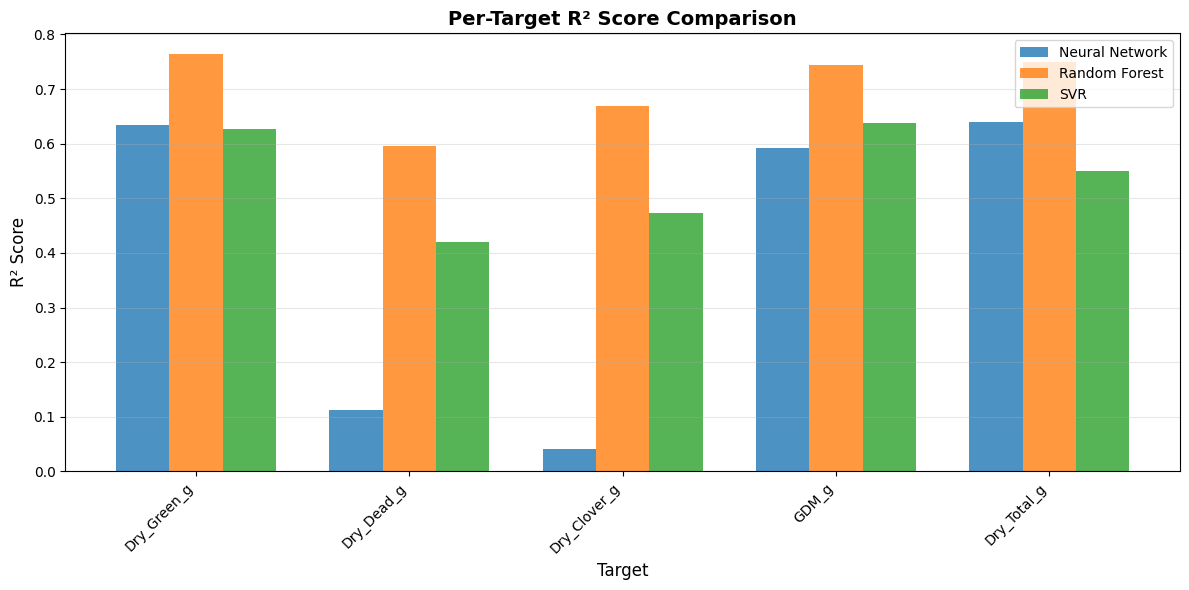

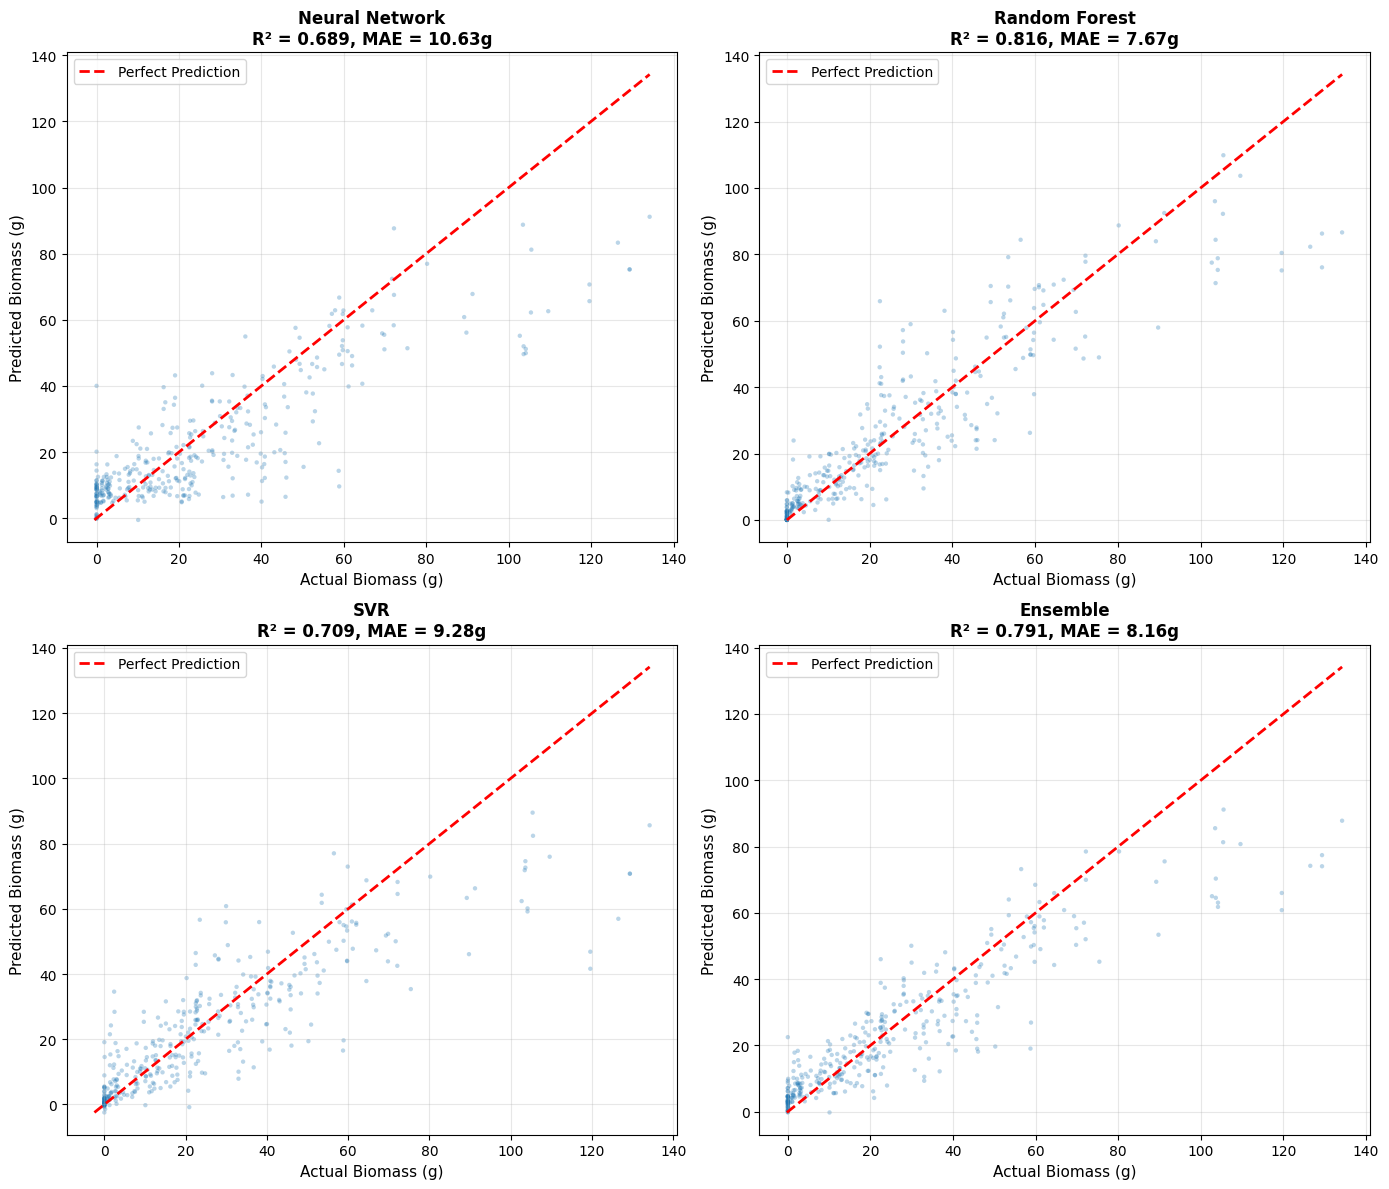

In [57]:
# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n📊 Creating visualizations...")

# Figure 1: Per-target R² comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(TARGETS))
width = 0.25

ax.bar(x - width, nn_r2_scores, width, label='Neural Network', alpha=0.8)
ax.bar(x, rf_r2_scores, width, label='Random Forest', alpha=0.8)
ax.bar(x + width, svr_r2_scores, width, label='SVR', alpha=0.8)

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Per-Target R² Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(TARGETS, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('r2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Figure 2: Scatter plots for each model
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

models = [
    ('Neural Network', nn_preds, nn_targets),
    ('Random Forest', rf_preds, y_val_rf),
    ('SVR', svr_preds, y_val_svr),
    ('Ensemble', ensemble_preds, nn_targets)
]

for idx, (name, preds, targets) in enumerate(models):
    ax = axes[idx]
    
    ax.scatter(targets.flatten(), preds.flatten(), alpha=0.3, s=10, edgecolors='none')
    
    max_val = max(targets.max(), preds.max())
    min_val = min(targets.min(), preds.min())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    r2 = r2_score(targets.flatten(), preds.flatten())
    mae = mean_absolute_error(targets.flatten(), preds.flatten())
    
    ax.set_xlabel('Actual Biomass (g)', fontsize=11)
    ax.set_ylabel('Predicted Biomass (g)', fontsize=11)
    ax.set_title(f'{name}\nR² = {r2:.3f}, MAE = {mae:.2f}g', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_scatter_all.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

"""
=============================================================================
ADVANCED VISUALIZATIONS AND METRICS
=============================================================================
Add this code after your model training to get comprehensive visualizations
=============================================================================
"""

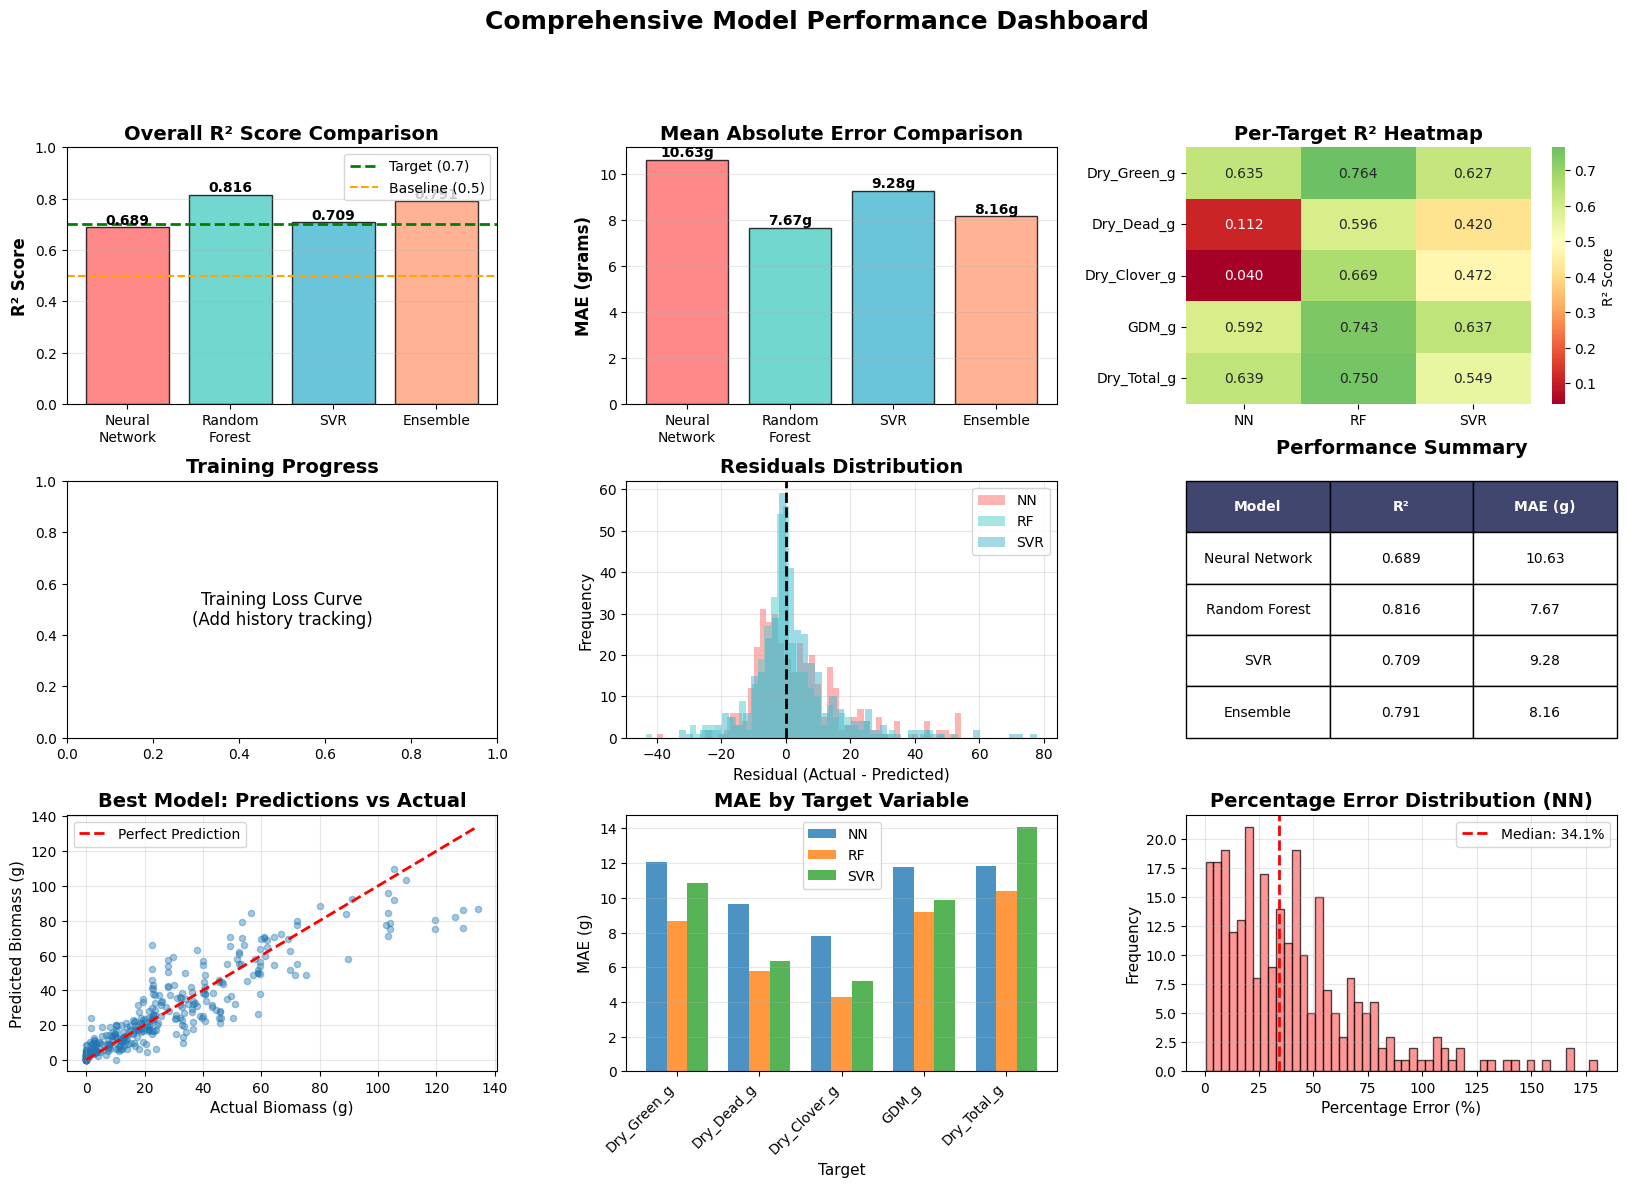

In [58]:
# ============================================================================
# VISUALIZATION 1: Comprehensive Model Comparison Dashboard
# ============================================================================

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1.1 Overall R² Comparison (Bar Chart)
ax1 = fig.add_subplot(gs[0, 0])
models_list = ['Neural\nNetwork', 'Random\nForest', 'SVR', 'Ensemble']
r2_values = [overall_r2_nn, overall_r2_rf, overall_r2_svr, overall_r2_ensemble]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

bars = ax1.bar(models_list, r2_values, color=colors, alpha=0.8, edgecolor='black')
ax1.axhline(y=0.7, color='green', linestyle='--', linewidth=2, label='Target (0.7)')
ax1.axhline(y=0.5, color='orange', linestyle='--', linewidth=1.5, label='Baseline (0.5)')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Overall R² Score Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 1.2 MAE Comparison (Bar Chart)
ax2 = fig.add_subplot(gs[0, 1])
mae_values = [overall_mae_nn, overall_mae_rf, overall_mae_svr, overall_mae_ensemble]
bars = ax2.bar(models_list, mae_values, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('MAE (grams)', fontsize=12, fontweight='bold')
ax2.set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}g', ha='center', va='bottom', fontweight='bold')

# 1.3 Per-Target R² Heatmap
ax3 = fig.add_subplot(gs[0, 2])
r2_matrix = np.array([nn_r2_scores, rf_r2_scores, svr_r2_scores]).T
sns.heatmap(r2_matrix, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5,
            xticklabels=['NN', 'RF', 'SVR'],
            yticklabels=TARGETS, ax=ax3, cbar_kws={'label': 'R² Score'})
ax3.set_title('Per-Target R² Heatmap', fontsize=14, fontweight='bold')

# 1.4 Training Loss Curves (if you saved history)
ax4 = fig.add_subplot(gs[1, 0])
# This assumes you saved training history - if not, skip this
ax4.text(0.5, 0.5, 'Training Loss Curve\n(Add history tracking)', 
         ha='center', va='center', fontsize=12)
ax4.set_title('Training Progress', fontsize=14, fontweight='bold')

# 1.5 Residuals Distribution
ax5 = fig.add_subplot(gs[1, 1])
nn_residuals = (nn_targets - nn_preds).flatten()
rf_residuals = (y_val_rf - rf_preds).flatten()
svr_residuals = (y_val_svr - svr_preds).flatten()

ax5.hist(nn_residuals, bins=50, alpha=0.5, label='NN', color=colors[0])
ax5.hist(rf_residuals, bins=50, alpha=0.5, label='RF', color=colors[1])
ax5.hist(svr_residuals, bins=50, alpha=0.5, label='SVR', color=colors[2])
ax5.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax5.set_xlabel('Residual (Actual - Predicted)', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('Residuals Distribution', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 1.6 Model Performance Summary Table
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')

summary_data = []
for i, model_name in enumerate(['Neural Network', 'Random Forest', 'SVR', 'Ensemble']):
    if i < 3:
        r2_val = r2_values[i]
        mae_val = mae_values[i]
    else:
        r2_val = overall_r2_ensemble
        mae_val = overall_mae_ensemble
    
    summary_data.append([model_name, f'{r2_val:.3f}', f'{mae_val:.2f}'])

table = ax6.table(cellText=summary_data,
                  colLabels=['Model', 'R²', 'MAE (g)'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(3):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax6.set_title('Performance Summary', fontsize=14, fontweight='bold', pad=20)

# 1.7 Prediction vs Actual for Best Model
ax7 = fig.add_subplot(gs[2, 0])
best_preds = nn_preds if overall_r2_nn == max(r2_values[:3]) else (rf_preds if overall_r2_rf == max(r2_values[:3]) else svr_preds)
best_targets = nn_targets if overall_r2_nn == max(r2_values[:3]) else (y_val_rf if overall_r2_rf == max(r2_values[:3]) else y_val_svr)

ax7.scatter(best_targets.flatten(), best_preds.flatten(), alpha=0.4, s=20)
max_val = max(best_targets.max(), best_preds.max())
min_val = min(best_targets.min(), best_preds.min())
ax7.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax7.set_xlabel('Actual Biomass (g)', fontsize=11)
ax7.set_ylabel('Predicted Biomass (g)', fontsize=11)
ax7.set_title('Best Model: Predictions vs Actual', fontsize=14, fontweight='bold')
ax7.legend()
ax7.grid(alpha=0.3)

# 1.8 Error Distribution by Target
ax8 = fig.add_subplot(gs[2, 1])
mae_by_target = []
for i in range(len(TARGETS)):
    mae_by_target.append([
        mean_absolute_error(nn_targets[:, i], nn_preds[:, i]),
        mean_absolute_error(y_val_rf[:, i], rf_preds[:, i]),
        mean_absolute_error(y_val_svr[:, i], svr_preds[:, i])
    ])

x = np.arange(len(TARGETS))
width = 0.25
ax8.bar(x - width, [m[0] for m in mae_by_target], width, label='NN', alpha=0.8)
ax8.bar(x, [m[1] for m in mae_by_target], width, label='RF', alpha=0.8)
ax8.bar(x + width, [m[2] for m in mae_by_target], width, label='SVR', alpha=0.8)
ax8.set_xlabel('Target', fontsize=11)
ax8.set_ylabel('MAE (g)', fontsize=11)
ax8.set_title('MAE by Target Variable', fontsize=14, fontweight='bold')
ax8.set_xticks(x)
ax8.set_xticklabels(TARGETS, rotation=45, ha='right')
ax8.legend()
ax8.grid(axis='y', alpha=0.3)

# 1.9 Percentage Error Distribution
ax9 = fig.add_subplot(gs[2, 2])
# Calculate percentage errors (avoiding division by zero)
nn_pct_errors = np.abs((nn_targets - nn_preds) / (nn_targets + 1e-6)) * 100
nn_pct_errors = nn_pct_errors[nn_pct_errors < 200]  # Remove outliers

ax9.hist(nn_pct_errors.flatten(), bins=50, alpha=0.7, color=colors[0], edgecolor='black')
ax9.axvline(x=np.median(nn_pct_errors), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {np.median(nn_pct_errors):.1f}%')
ax9.set_xlabel('Percentage Error (%)', fontsize=11)
ax9.set_ylabel('Frequency', fontsize=11)
ax9.set_title('Percentage Error Distribution (NN)', fontsize=14, fontweight='bold')
ax9.legend()
ax9.grid(alpha=0.3)

plt.suptitle('Comprehensive Model Performance Dashboard', 
             fontsize=18, fontweight='bold', y=0.995)
plt.savefig('comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

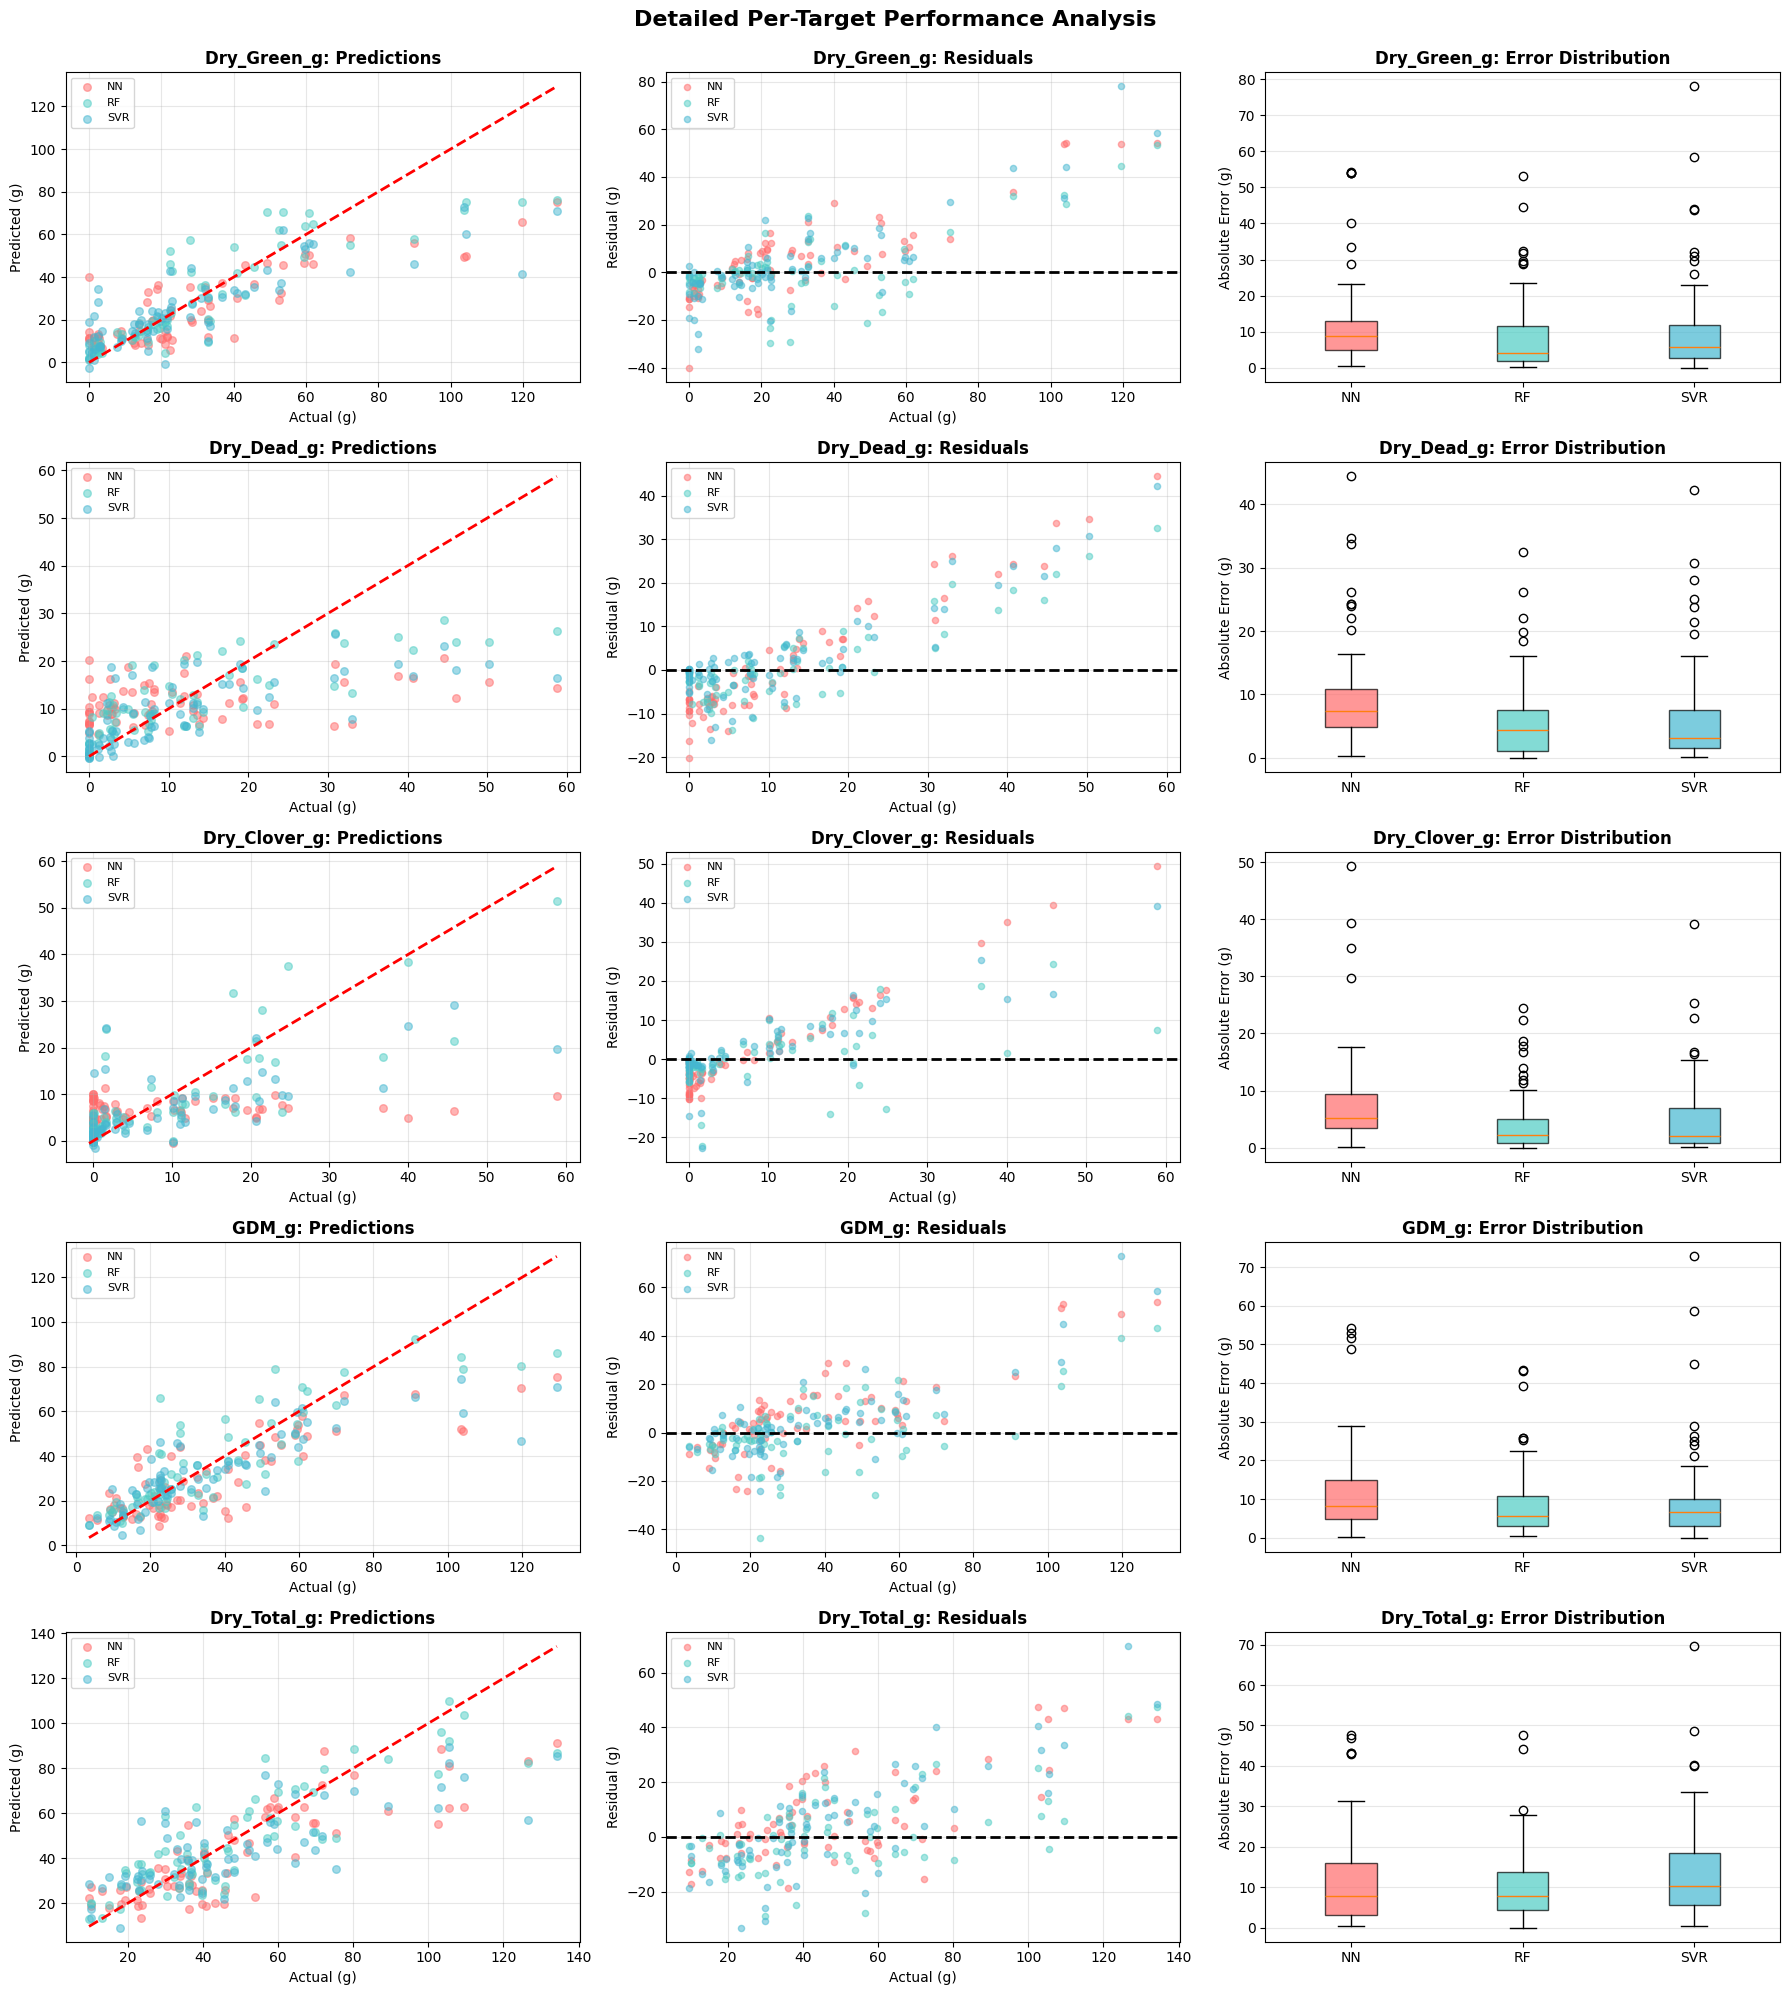

In [59]:
# ============================================================================
# VISUALIZATION 2: Detailed Per-Target Analysis
# ============================================================================

fig, axes = plt.subplots(5, 3, figsize=(18, 20))

for i, target_name in enumerate(TARGETS):
    # Column 1: Scatter plot for each target
    ax1 = axes[i, 0]
    ax1.scatter(nn_targets[:, i], nn_preds[:, i], alpha=0.5, s=30, label='NN', color=colors[0])
    ax1.scatter(y_val_rf[:, i], rf_preds[:, i], alpha=0.5, s=30, label='RF', color=colors[1])
    ax1.scatter(y_val_svr[:, i], svr_preds[:, i], alpha=0.5, s=30, label='SVR', color=colors[2])
    
    max_val = max(nn_targets[:, i].max(), nn_preds[:, i].max())
    min_val = min(nn_targets[:, i].min(), nn_preds[:, i].min())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    ax1.set_xlabel('Actual (g)', fontsize=10)
    ax1.set_ylabel('Predicted (g)', fontsize=10)
    ax1.set_title(f'{target_name}: Predictions', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=8)
    ax1.grid(alpha=0.3)
    
    # Column 2: Residual plot
    ax2 = axes[i, 1]
    nn_res = nn_targets[:, i] - nn_preds[:, i]
    rf_res = y_val_rf[:, i] - rf_preds[:, i]
    svr_res = y_val_svr[:, i] - svr_preds[:, i]
    
    ax2.scatter(nn_targets[:, i], nn_res, alpha=0.5, s=20, label='NN', color=colors[0])
    ax2.scatter(y_val_rf[:, i], rf_res, alpha=0.5, s=20, label='RF', color=colors[1])
    ax2.scatter(y_val_svr[:, i], svr_res, alpha=0.5, s=20, label='SVR', color=colors[2])
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)
    
    ax2.set_xlabel('Actual (g)', fontsize=10)
    ax2.set_ylabel('Residual (g)', fontsize=10)
    ax2.set_title(f'{target_name}: Residuals', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper left', fontsize=8)
    ax2.grid(alpha=0.3)
    
    # Column 3: Box plot of errors
    ax3 = axes[i, 2]
    error_data = [
        np.abs(nn_res),
        np.abs(rf_res),
        np.abs(svr_res)
    ]
    
    bp = ax3.boxplot(error_data, labels=['NN', 'RF', 'SVR'], patch_artist=True)
    for patch, color in zip(bp['boxes'], colors[:3]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_ylabel('Absolute Error (g)', fontsize=10)
    ax3.set_title(f'{target_name}: Error Distribution', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

plt.suptitle('Detailed Per-Target Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('per_target_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

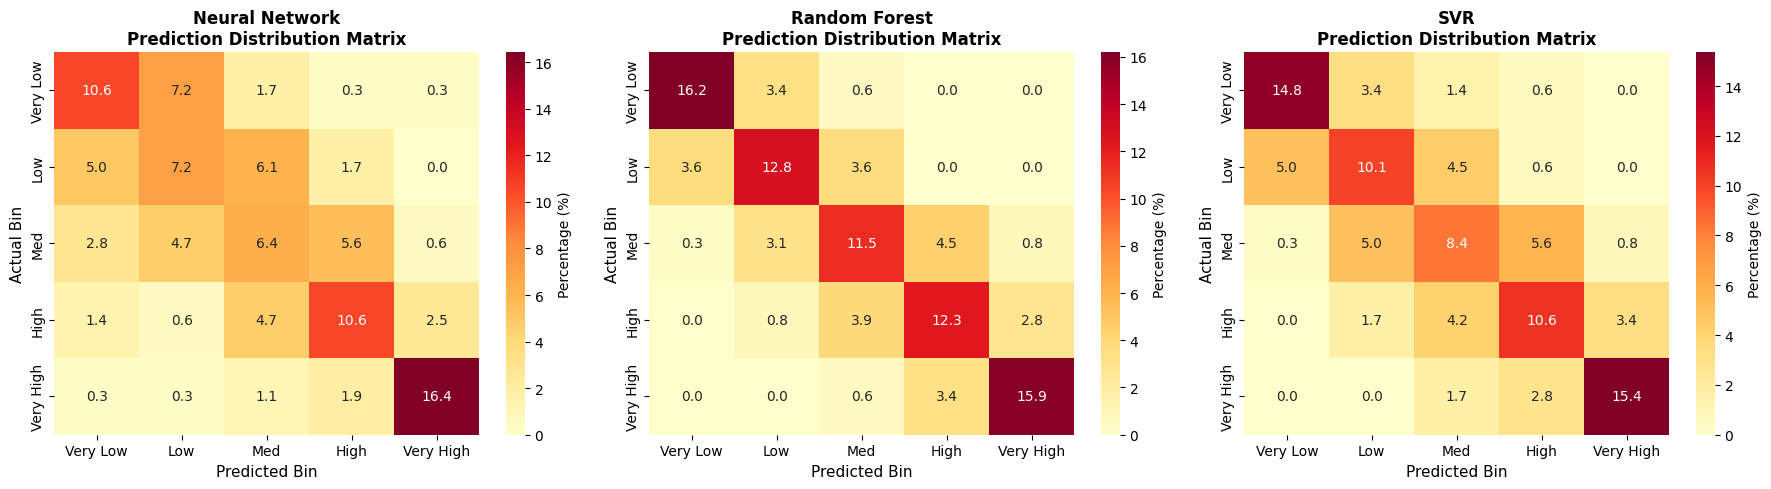

In [60]:
# ============================================================================
# VISUALIZATION 3: Confusion Matrix Style Heatmap
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('Neural Network', nn_preds, nn_targets),
    ('Random Forest', rf_preds, y_val_rf),
    ('SVR', svr_preds, y_val_svr)
]

for idx, (name, preds, targets) in enumerate(models_data):
    ax = axes[idx]
    
    # Create bins for actual vs predicted
    bins = 5
    actual_binned = np.digitize(targets.flatten(), bins=np.percentile(targets.flatten(), np.linspace(0, 100, bins+1)))
    pred_binned = np.digitize(preds.flatten(), bins=np.percentile(preds.flatten(), np.linspace(0, 100, bins+1)))
    
    # Create confusion-style matrix
    conf_matrix = np.zeros((bins, bins))
    for a, p in zip(actual_binned, pred_binned):
        if 1 <= a <= bins and 1 <= p <= bins:
            conf_matrix[a-1, p-1] += 1
    
    # Normalize
    conf_matrix = conf_matrix / conf_matrix.sum() * 100
    
    sns.heatmap(conf_matrix, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
                xticklabels=['Very Low', 'Low', 'Med', 'High', 'Very High'],
                yticklabels=['Very Low', 'Low', 'Med', 'High', 'Very High'],
                cbar_kws={'label': 'Percentage (%)'})
    ax.set_xlabel('Predicted Bin', fontsize=11)
    ax.set_ylabel('Actual Bin', fontsize=11)
    ax.set_title(f'{name}\nPrediction Distribution Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('prediction_distribution_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


Creating Visualization 3: Error Analysis...


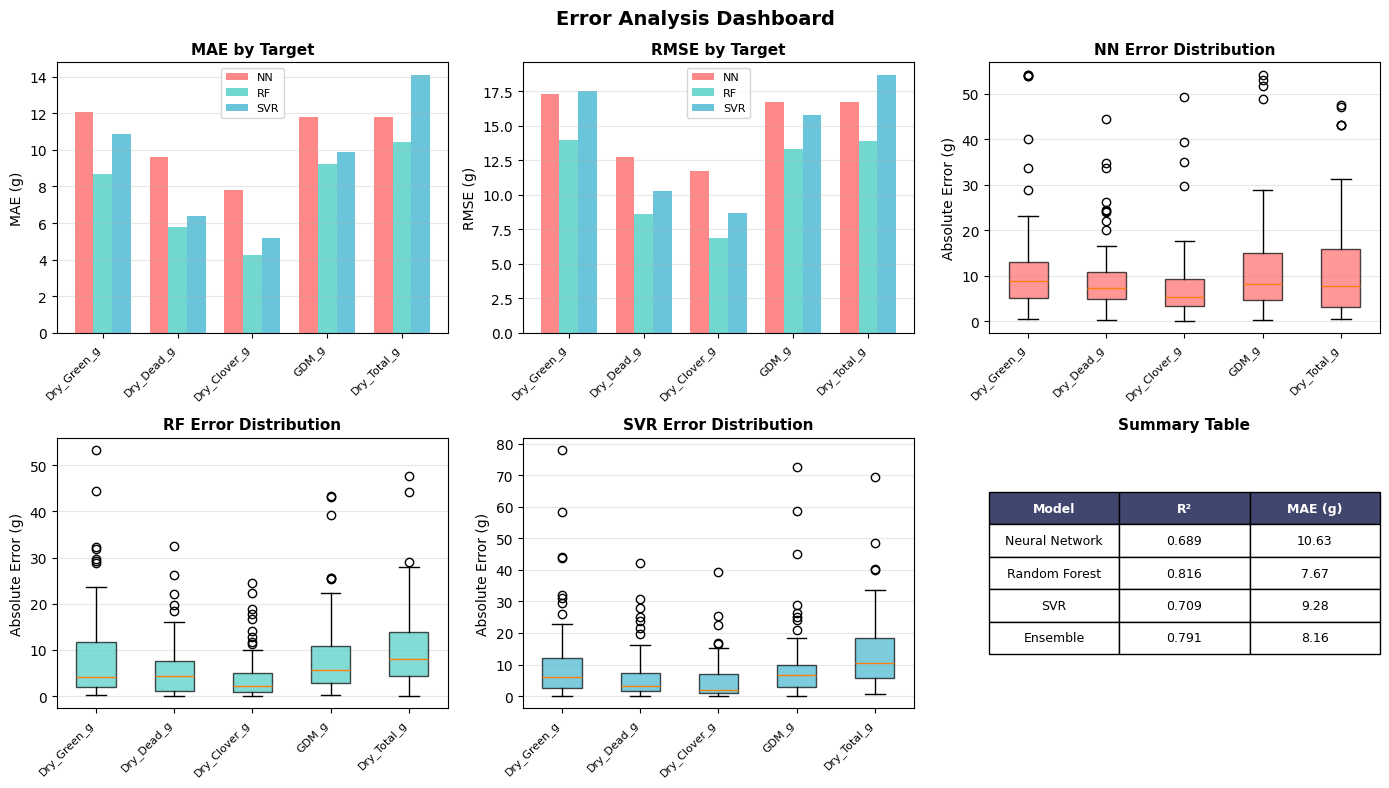

✅ Saved: error_analysis.png


In [61]:
# ============================================================================
# VISUALIZATION 3: Error Analysis
# ============================================================================

print("\nCreating Visualization 3: Error Analysis...")

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

# MAE by Target
ax = axes[0]
mae_by_target = []
for i in range(len(TARGETS)):
    mae_by_target.append([
        mean_absolute_error(nn_targets[:, i], nn_preds[:, i]),
        mean_absolute_error(y_val_rf[:, i], rf_preds[:, i]),
        mean_absolute_error(y_val_svr[:, i], svr_preds[:, i])
    ])

x = np.arange(len(TARGETS))
width = 0.25
ax.bar(x - width, [m[0] for m in mae_by_target], width, label='NN', alpha=0.8, color=colors[0])
ax.bar(x, [m[1] for m in mae_by_target], width, label='RF', alpha=0.8, color=colors[1])
ax.bar(x + width, [m[2] for m in mae_by_target], width, label='SVR', alpha=0.8, color=colors[2])
ax.set_ylabel('MAE (g)', fontsize=10)
ax.set_title('MAE by Target', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(TARGETS, rotation=45, ha='right', fontsize=8)
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

# RMSE by Target
ax = axes[1]
rmse_by_target = []
for i in range(len(TARGETS)):
    rmse_by_target.append([
        np.sqrt(mean_squared_error(nn_targets[:, i], nn_preds[:, i])),
        np.sqrt(mean_squared_error(y_val_rf[:, i], rf_preds[:, i])),
        np.sqrt(mean_squared_error(y_val_svr[:, i], svr_preds[:, i]))
    ])

ax.bar(x - width, [m[0] for m in rmse_by_target], width, label='NN', alpha=0.8, color=colors[0])
ax.bar(x, [m[1] for m in rmse_by_target], width, label='RF', alpha=0.8, color=colors[1])
ax.bar(x + width, [m[2] for m in rmse_by_target], width, label='SVR', alpha=0.8, color=colors[2])
ax.set_ylabel('RMSE (g)', fontsize=10)
ax.set_title('RMSE by Target', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(TARGETS, rotation=45, ha='right', fontsize=8)
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

# Error Box Plot for Neural Network
ax = axes[2]
nn_errors_by_target = [np.abs(nn_targets[:, i] - nn_preds[:, i]) for i in range(len(TARGETS))]
bp = ax.boxplot(nn_errors_by_target, labels=TARGETS, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor(colors[0])
    patch.set_alpha(0.7)
ax.set_ylabel('Absolute Error (g)', fontsize=10)
ax.set_title('NN Error Distribution', fontsize=11, fontweight='bold')
ax.set_xticklabels(TARGETS, rotation=45, ha='right', fontsize=8)
ax.grid(axis='y', alpha=0.3)

# Error Box Plot for Random Forest
ax = axes[3]
rf_errors_by_target = [np.abs(y_val_rf[:, i] - rf_preds[:, i]) for i in range(len(TARGETS))]
bp = ax.boxplot(rf_errors_by_target, labels=TARGETS, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor(colors[1])
    patch.set_alpha(0.7)
ax.set_ylabel('Absolute Error (g)', fontsize=10)
ax.set_title('RF Error Distribution', fontsize=11, fontweight='bold')
ax.set_xticklabels(TARGETS, rotation=45, ha='right', fontsize=8)
ax.grid(axis='y', alpha=0.3)

# Error Box Plot for SVR
ax = axes[4]
svr_errors_by_target = [np.abs(y_val_svr[:, i] - svr_preds[:, i]) for i in range(len(TARGETS))]
bp = ax.boxplot(svr_errors_by_target, labels=TARGETS, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor(colors[2])
    patch.set_alpha(0.7)
ax.set_ylabel('Absolute Error (g)', fontsize=10)
ax.set_title('SVR Error Distribution', fontsize=11, fontweight='bold')
ax.set_xticklabels(TARGETS, rotation=45, ha='right', fontsize=8)
ax.grid(axis='y', alpha=0.3)

# Model Performance Summary Table
ax = axes[5]
ax.axis('off')
summary_data = [
    ['Neural Network', f'{overall_r2_nn:.3f}', f'{overall_mae_nn:.2f}'],
    ['Random Forest', f'{overall_r2_rf:.3f}', f'{overall_mae_rf:.2f}'],
    ['SVR', f'{overall_r2_svr:.3f}', f'{overall_mae_svr:.2f}'],
    ['Ensemble', f'{overall_r2_ensemble:.3f}', f'{overall_mae_ensemble:.2f}']
]

table = ax.table(cellText=summary_data,
                 colLabels=['Model', 'R²', 'MAE (g)'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0.2, 1, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.8)

for i in range(3):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax.set_title('Summary Table', fontsize=11, fontweight='bold')

plt.suptitle('Error Analysis Dashboard', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('error_analysis.png', dpi=120, bbox_inches='tight')
plt.show()
plt.close()
print("✅ Saved: error_analysis.png")


Creating Visualization 4: Feature Importance...


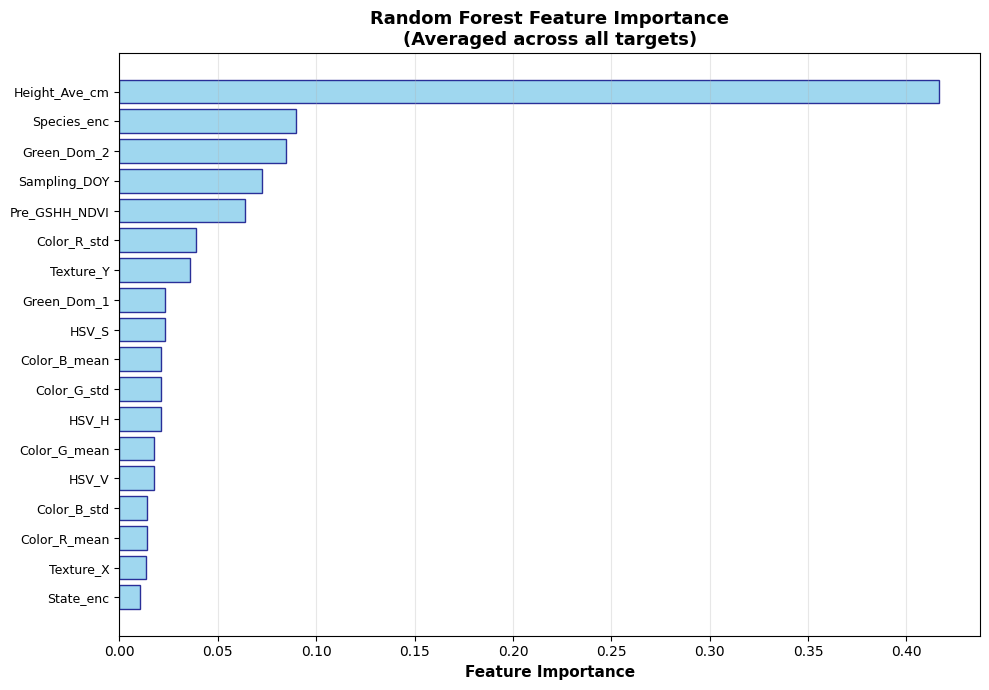

✅ Saved: feature_importance.png


In [62]:
# ============================================================================
# VISUALIZATION 4: Feature Importance (Random Forest)
# ============================================================================

print("\nCreating Visualization 4: Feature Importance...")

fig, ax = plt.subplots(figsize=(10, 7))

feature_names = ['Color_R_mean', 'Color_R_std', 'Color_G_mean', 'Color_G_std', 
                 'Color_B_mean', 'Color_B_std', 'Texture_X', 'Texture_Y',
                 'HSV_H', 'HSV_S', 'HSV_V', 'Green_Dom_1', 'Green_Dom_2'] + META_COLS

# Average importance across all targets
avg_importance = np.zeros(len(feature_names))
for estimator in rf_model.estimators_:
    avg_importance += estimator.feature_importances_
avg_importance /= len(rf_model.estimators_)

# Sort by importance
sorted_idx = np.argsort(avg_importance)
pos = np.arange(sorted_idx.shape[0])

ax.barh(pos, avg_importance[sorted_idx], align='center', 
        color='skyblue', alpha=0.8, edgecolor='navy')
ax.set_yticks(pos)
ax.set_yticklabels([feature_names[i] for i in sorted_idx], fontsize=9)
ax.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
ax.set_title('Random Forest Feature Importance\n(Averaged across all targets)', 
             fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=120, bbox_inches='tight')
plt.show()
plt.close()
print("✅ Saved: feature_importance.png")


Creating Visualization 5: Ensemble Analysis...


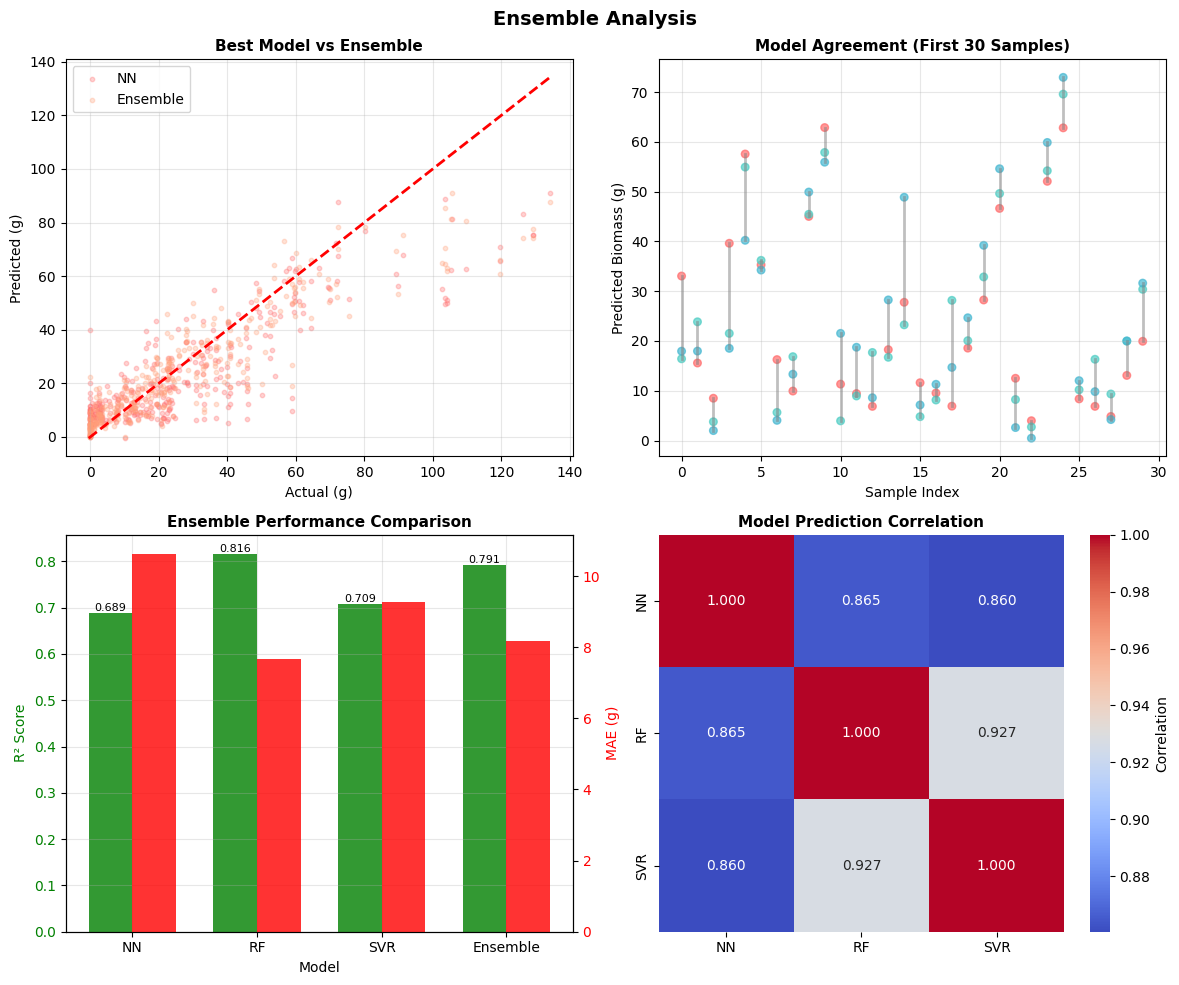

✅ Saved: ensemble_analysis.png


In [63]:
 #============================================================================
# VISUALIZATION 5: Ensemble Analysis
# ============================================================================

print("\nCreating Visualization 5: Ensemble Analysis...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Best model vs Ensemble
ax = axes[0, 0]
ensemble_preds = (nn_preds + rf_preds + svr_preds) / 3

ax.scatter(nn_targets.flatten(), nn_preds.flatten(), alpha=0.3, s=10, label='NN', color=colors[0])
ax.scatter(nn_targets.flatten(), ensemble_preds.flatten(), alpha=0.3, s=10, label='Ensemble', color=colors[3])

max_val = max(nn_targets.max(), nn_preds.max(), ensemble_preds.max())
min_val = min(nn_targets.min(), nn_preds.min(), ensemble_preds.min())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

ax.set_xlabel('Actual (g)', fontsize=10)
ax.set_ylabel('Predicted (g)', fontsize=10)
ax.set_title('Best Model vs Ensemble', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Model Agreement
ax = axes[0, 1]
for i in range(min(30, len(nn_targets))):
    predictions = [nn_preds.flatten()[i], rf_preds.flatten()[i], svr_preds.flatten()[i]]
    min_pred = min(predictions)
    max_pred = max(predictions)
    ax.plot([i, i], [min_pred, max_pred], 'gray', alpha=0.5, linewidth=2)
    ax.scatter([i]*3, predictions, c=colors[:3], s=30, alpha=0.7)

ax.set_xlabel('Sample Index', fontsize=10)
ax.set_ylabel('Predicted Biomass (g)', fontsize=10)
ax.set_title('Model Agreement (First 30 Samples)', fontsize=11, fontweight='bold')
ax.grid(alpha=0.3)

# Ensemble Improvement
ax = axes[1, 0]
models = ['NN', 'RF', 'SVR', 'Ensemble']
r2_scores = [overall_r2_nn, overall_r2_rf, overall_r2_svr, overall_r2_ensemble]
mae_scores = [overall_mae_nn, overall_mae_rf, overall_mae_svr, overall_mae_ensemble]

x = np.arange(len(models))
width = 0.35

ax2 = ax.twinx()
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²', alpha=0.8, color='green')
bars2 = ax2.bar(x + width/2, mae_scores, width, label='MAE', alpha=0.8, color='red')

ax.set_ylabel('R² Score', fontsize=10, color='green')
ax2.set_ylabel('MAE (g)', fontsize=10, color='red')
ax.set_xlabel('Model', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_title('Ensemble Performance Comparison', fontsize=11, fontweight='bold')
ax.tick_params(axis='y', labelcolor='green')
ax2.tick_params(axis='y', labelcolor='red')
ax.grid(alpha=0.3)

# Add values on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Correlation between models
ax = axes[1, 1]
corr_matrix = np.corrcoef([nn_preds.flatten(), rf_preds.flatten(), svr_preds.flatten()])
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            xticklabels=['NN', 'RF', 'SVR'],
            yticklabels=['NN', 'RF', 'SVR'], ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Model Prediction Correlation', fontsize=11, fontweight='bold')

plt.suptitle('Ensemble Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ensemble_analysis.png', dpi=120, bbox_inches='tight')
plt.show()
plt.close()
print("✅ Saved: ensemble_analysis.png")

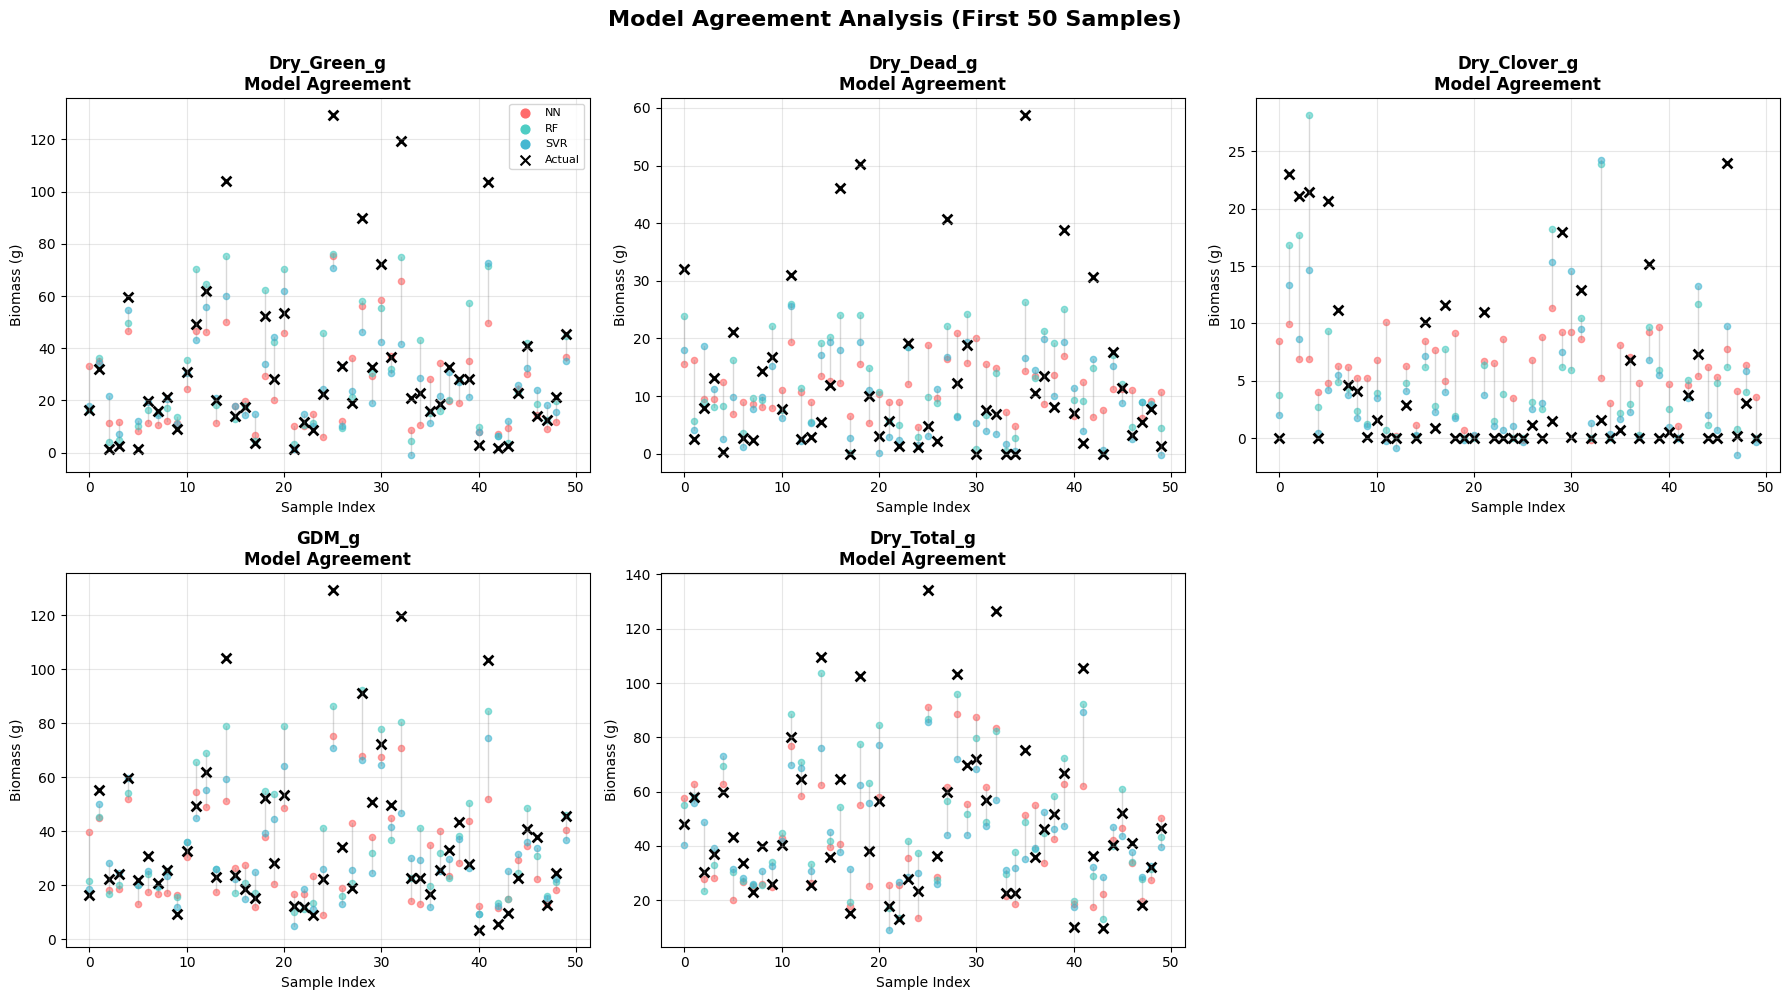

In [64]:
# ============================================================================
# VISUALIZATION 6: Model Agreement Analysis
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, target_name in enumerate(TARGETS):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Calculate agreement between models
    nn_pred_target = nn_preds[:, i]
    rf_pred_target = rf_preds[:, i]
    svr_pred_target = svr_preds[:, i]
    actual = nn_targets[:, i]
    
    # Plot prediction ranges
    for j in range(min(50, len(actual))):  # Show first 50 samples
        predictions = [nn_pred_target[j], rf_pred_target[j], svr_pred_target[j]]
        min_pred = min(predictions)
        max_pred = max(predictions)
        
        # Draw range line
        ax.plot([j, j], [min_pred, max_pred], 'gray', alpha=0.3, linewidth=1)
        
        # Plot individual predictions
        ax.scatter(j, nn_pred_target[j], color=colors[0], s=20, alpha=0.6)
        ax.scatter(j, rf_pred_target[j], color=colors[1], s=20, alpha=0.6)
        ax.scatter(j, svr_pred_target[j], color=colors[2], s=20, alpha=0.6)
        
        # Plot actual value
        ax.scatter(j, actual[j], color='black', marker='x', s=50, linewidths=2)
    
    ax.set_xlabel('Sample Index', fontsize=10)
    ax.set_ylabel('Biomass (g)', fontsize=10)
    ax.set_title(f'{target_name}\nModel Agreement', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add legend only to first subplot
    if i == 0:
        ax.scatter([], [], color=colors[0], s=40, label='NN')
        ax.scatter([], [], color=colors[1], s=40, label='RF')
        ax.scatter([], [], color=colors[2], s=40, label='SVR')
        ax.scatter([], [], color='black', marker='x', s=50, label='Actual')
        ax.legend(loc='upper right', fontsize=8)

# Remove extra subplot
axes[1, 2].remove()

plt.suptitle('Model Agreement Analysis (First 50 Samples)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('model_agreement.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [65]:
# ============================================================================
# SUMMARY: Print All Generated Files
# ============================================================================

print("\n" + "="*70)
print("📊 VISUALIZATION FILES GENERATED")
print("="*70)
print("✅ comprehensive_dashboard.png - Overall performance dashboard")
print("✅ per_target_analysis.png - Detailed analysis for each target")
print("✅ prediction_distribution_matrix.png - Confusion-style matrices")
print("✅ error_analysis.png - Error metrics and distributions")
print("✅ feature_importance.png - Random Forest feature importance")
print("✅ ensemble_analysis.png - Ensemble method analysis")
print("✅ model_agreement.png - Agreement between models")
print("\n🎉 All visualizations completed!")
print("="*70)


📊 VISUALIZATION FILES GENERATED
✅ comprehensive_dashboard.png - Overall performance dashboard
✅ per_target_analysis.png - Detailed analysis for each target
✅ prediction_distribution_matrix.png - Confusion-style matrices
✅ error_analysis.png - Error metrics and distributions
✅ feature_importance.png - Random Forest feature importance
✅ ensemble_analysis.png - Ensemble method analysis
✅ model_agreement.png - Agreement between models

🎉 All visualizations completed!


In [66]:

# ============================================================================
# GENERATE TEST PREDICTIONS
# ============================================================================

print("\n" + "="*70)
print("🎯 GENERATING TEST PREDICTIONS")
print("="*70)

# Choose which model to use for submission
use_ensemble = True  # Set to False to use best individual model

if use_ensemble:
    print("Using Ensemble predictions (average of all 3 models)")
    
    # Neural Network predictions
    test_ds = BiomassDataset(test_df, f"{DATA_DIR}/test", test_tfms, train=False)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)
    
    nn_model.eval()
    nn_test_preds = []
    test_paths = []
    
    with torch.no_grad():
        for img, meta, image_paths in test_loader:
            img, meta = img.to(DEVICE), meta.to(DEVICE)
            outputs = nn_model(img, meta).cpu().numpy()
            nn_test_preds.append(outputs)
            test_paths.extend(image_paths)
    
    nn_test_preds = np.vstack(nn_test_preds)
    
    # Random Forest and SVR predictions
    print("Extracting test features...")
    test_img_features = []
    for i, img_path in enumerate(test_df["image_path"]):
        if i % 50 == 0:
            print(f"  Progress: {i}/{len(test_df)}", end='\r')
        features = extract_image_features(img_path, f"{DATA_DIR}/test")
        test_img_features.append(features)
    print(f"  Completed: {len(test_df)}/{len(test_df)}")
    
    X_test = np.hstack([np.array(test_img_features), test_df[META_COLS].values])
    X_test = scaler_rf.transform(X_test)
    
    rf_test_preds = rf_model.predict(X_test)
    svr_test_preds = svr_model.predict(X_test)
    
    # Ensemble
    final_preds = (nn_test_preds + rf_test_preds + svr_test_preds) / 3
    
else:
    print(f"Using best individual model: {best_model_name}")
    
    if best_model_name == 'Neural Network':
        test_ds = BiomassDataset(test_df, f"{DATA_DIR}/test", test_tfms, train=False)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)
        
        nn_model.eval()
        final_preds = []
        test_paths = []
        
        with torch.no_grad():
            for img, meta, image_paths in test_loader:
                img, meta = img.to(DEVICE), meta.to(DEVICE)
                outputs = nn_model(img, meta).cpu().numpy()
                final_preds.append(outputs)
                test_paths.extend(image_paths)
        
        final_preds = np.vstack(final_preds)
    
    else:
        print("Extracting test features...")
        test_img_features = []
        for i, img_path in enumerate(test_df["image_path"]):
            features = extract_image_features(img_path, f"{DATA_DIR}/test")
            test_img_features.append(features)
        
        X_test = np.hstack([np.array(test_img_features), test_df[META_COLS].values])
        X_test = scaler_rf.transform(X_test)
        
        if best_model_name == 'Random Forest':
            final_preds = rf_model.predict(X_test)
        else:
            final_preds = svr_model.predict(X_test)
        
        test_paths = test_df["image_path"].tolist()


# Create submission
rows = []
for i, img_path in enumerate(test_paths):
    image_id = img_path.split("/")[-1].replace(".jpg", "")
    for j, tgt in enumerate(TARGETS):
        rows.append((f"{image_id}__{tgt}", max(final_preds[i, j], 0)))

submission = pd.DataFrame(rows, columns=["sample_id", "target"])

print(f"\n✅ Generated {len(submission)} predictions")
print(f"Sample submission preview:")
print(submission.head(10))

submission.to_csv("submission.csv", index=False)
print("\n✅ Submission saved to 'submission.csv'")


🎯 GENERATING TEST PREDICTIONS
Using Ensemble predictions (average of all 3 models)
Extracting test features...
  Completed: 5/5

✅ Generated 25 predictions
Sample submission preview:
                    sample_id     target
0   ID1001187975__Dry_Green_g  27.190071
1    ID1001187975__Dry_Dead_g  17.502668
2  ID1001187975__Dry_Clover_g   8.221411
3         ID1001187975__GDM_g  34.164469
4   ID1001187975__Dry_Total_g  53.983086
5   ID1001187975__Dry_Green_g  27.190071
6    ID1001187975__Dry_Dead_g  17.502668
7  ID1001187975__Dry_Clover_g   8.221411
8         ID1001187975__GDM_g  34.164469
9   ID1001187975__Dry_Total_g  53.983086

✅ Submission saved to 'submission.csv'


In [67]:
# Remove duplicates
submission = submission.drop_duplicates(subset=['sample_id'])
print(f"Final submission shape: {submission.shape}")
submission.to_csv("submission.csv", index=False)

Final submission shape: (5, 2)


In [68]:
# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*70)
print("📋 SUMMARY")
print("="*70)

print("\n✅ Three Algorithms Implemented:")
print("   1. Neural Network (CNN + MLP) - Deep Learning")
print("   2. Random Forest - Ensemble Method")
print("   3. Support Vector Regression - Regression + SVM")

print(f"\n📊 Performance Summary:")
print(comparison_df.to_string(index=False))

print(f"\n🎯 Final Submission:")
if use_ensemble:
    print(f"   Method: Ensemble (average of 3 models)")
    print(f"   Expected R²: {overall_r2_ensemble:.3f}")
else:
    print(f"   Method: {best_model_name}")
    print(f"   Expected R²: {best_r2:.3f}")

print("\n💾 Saved Files:")
print("   - submission.csv")
print("   - neural_network_model.pth")
print("   - random_forest_model.pkl")
print("   - svr_model.pkl")
print("   - feature_scaler.pkl")
print("   - r2_comparison.png")
print("   - prediction_scatter_all.png")

print("\n" + "="*70)
print("🎉 ALL DONE! Your submission is ready.")
print("="*70)


📋 SUMMARY

✅ Three Algorithms Implemented:
   1. Neural Network (CNN + MLP) - Deep Learning
   2. Random Forest - Ensemble Method
   3. Support Vector Regression - Regression + SVM

📊 Performance Summary:
                Algorithm  Overall R²  Overall MAE (g)        Technique
           Neural Network    0.689168        10.629966  Neural Networks
            Random Forest    0.816320         7.669525  Ensemble Method
Support Vector Regression    0.708827         9.280512 Regression + SVM

🎯 Final Submission:
   Method: Ensemble (average of 3 models)
   Expected R²: 0.791

💾 Saved Files:
   - submission.csv
   - neural_network_model.pth
   - random_forest_model.pkl
   - svr_model.pkl
   - feature_scaler.pkl
   - r2_comparison.png
   - prediction_scatter_all.png

🎉 ALL DONE! Your submission is ready.
